In [1]:
import os
import warnings
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms
import torch.optim as optim
from einops import rearrange
from tqdm import tqdm
from torchvision.transforms import GaussianBlur
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, mean_squared_error, f1_score, confusion_matrix,r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import CosineAnnealingLR

from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

from einops import rearrange
from tqdm import tqdm
from torchvision.transforms import GaussianBlur
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, mean_squared_error, f1_score, confusion_matrix, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from scipy.stats import gaussian_kde
import torchvision.models as models


# Device configuration and seeding
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)


In [2]:

# New class for labeled dataset
class JetDatasetLabeled(Dataset):
    def __init__(self, file_path, jet_key="jet", y_key="Y", pt_key="pT", m_key="m"):
        self.file_path = file_path
        self.jet_key = jet_key
        self.y_key = y_key
        self.pt_key = pt_key
        self.m_key = m_key
        
        with h5py.File(file_path, 'r') as f:
            self.length = f[jet_key].shape[0]
            
    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        with h5py.File(self.file_path, 'r') as f:
            jet = f[self.jet_key][idx]
            y = f[self.y_key][idx]
            pt = f[self.pt_key][idx]
            m = f[self.m_key][idx]
            
        # Convert shape to [channels, eta, phi]
        jet = torch.tensor(jet, dtype=torch.float32).permute(2, 0, 1)
        y = torch.tensor(y, dtype=torch.float32)
        pt = torch.tensor(pt, dtype=torch.float32)
        m = torch.tensor(m, dtype=torch.float32)
        
        return jet, y, pt, m

In [18]:
class ParticleTransformer(nn.Module):
    """Hybrid CNN-Transformer for calorimeter images"""
    def __init__(self, in_channels=8, latent_dim=256):
        super().__init__()
        
        # CNN backbone with residual connections for better gradient flow
        self.cnn = nn.Sequential(
            nn.Conv2d(8, 64, kernel_size=3, padding=1),
            nn.GELU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),  # Output: [64, ~62, ~62]

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.GELU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),  # Output: [128, ~31, ~31]

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.GELU(),
            nn.BatchNorm2d(256),
            nn.AdaptiveAvgPool2d((4, 4))   # Output: [256, 4, 4]
        )
        
        # Position encoding for transformer
        
        self.pos_embedding = nn.Parameter(torch.randn(1, 16, 256) * 0.02)
        
        # Transformer with improved parameters
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=256,
                nhead=8,
                dim_feedforward=1024,
                dropout=0.1,
                activation='gelu',
                batch_first=True,
                norm_first=True  # Pre-norm architecture for stability
            ),
            num_layers=2
        )
        
        # Projection head
        self.head = nn.Sequential(
            nn.Linear(256, 512),
            nn.GELU(),
            nn.LayerNorm(512),
            nn.Dropout(0.1),
            nn.Linear(512, latent_dim)
        )
    
    def forward(self, x):
        # CNN processing
        x = self.cnn(x)  # [bs, 256, 4, 4]
        
        # Prepare for transformer
        x = rearrange(x, 'b c h w -> b (h w) c')  # [bs, 16, 256]
        
        # Add position embeddings
        x = x + self.pos_embedding
        
        # Transformer processing
        x = self.transformer(x)  # [bs, 16, 256]
        
        # Aggregation with attention pooling
        x = x.mean(dim=1)  # [bs, 256]
        
        # Projection
        return self.head(x)

In [19]:
class SimCLRModel(nn.Module):
    def __init__(self, latent_dim=256, projection_dim=128):
        super().__init__()
        self.encoder = ParticleTransformer(latent_dim=latent_dim)
        self.projector = nn.Sequential(
            nn.Linear(latent_dim, latent_dim),
            nn.GELU(),
            nn.LayerNorm(latent_dim),
            nn.Linear(latent_dim, projection_dim)
        )

    def forward(self, x):
        features = self.encoder(x)
        projections = self.projector(features)
        return features, projections       

In [20]:

def extract_features(model, dataloader):
    model.eval()
    features_list = []
    y_list = []
    pt_list = []
    m_list = []
    
    with torch.no_grad():
        for jets, y, pt, m in tqdm(dataloader, desc="Extracting features"):
            jets = jets.to(device)
            features, _ = model(jets)
            features_list.append(features.cpu())
            y_list.append(y)
            pt_list.append(pt)
            m_list.append(m)
    
    # Concatenate all batches
    features = torch.cat(features_list, dim=0)
    y = torch.cat(y_list, dim=0)
    pt = torch.cat(pt_list, dim=0)
    m = torch.cat(m_list, dim=0)
    
    return features, y, pt, m



In [21]:

class ClassificationModel(nn.Module):
    def __init__(self, input_dim, num_classes=1):
        super(ClassificationModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
            nn.Sigmoid()  # Ensure the output is in the range [0, 1] for binary classification
        )

    def forward(self, x):
        return self.fc(x)

In [ ]:
def load_model(checkpoint_name, model, device):
    checkpoint_path = os.path.join("/kaggle/input/greattt", checkpoint_name)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded model from {checkpoint_name} (Epoch {checkpoint['epoch']} with Loss {checkpoint['loss']:.4f})")
    return model


labeled_file_path = "/kaggle/input/dataset-specific-labelled-full-only-for-2i/Dataset_Specific_labelled_full_only_for_2i.h5"
latent_dim = 256

# Initialize model
ssl_model = SimCLRModel(latent_dim=latent_dim).to(device)# Load the best model
ssl_model = load_model("best_model (4).pt", ssl_model, device)
ssl_model.eval()


print("Loading labeled dataset...")
batch_size = 64

labeled_dataset = JetDatasetLabeled(labeled_file_path)
labeled_loader = DataLoader(
        labeled_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
)

# Extract features
features, y_labels, _, _ = extract_features(ssl_model, labeled_loader)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
<ipython-input-23-ea2f7e39b0d9>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't h

Loaded model from best_model (4).pt (Epoch 29 with Loss 0.0254)
Loading labeled dataset...


Extracting features: 100%|██████████| 157/157 [00:36<00:00,  4.32it/s]


In [24]:
X_train, X_val, y_train, y_val= train_test_split(
    features, y_labels, test_size=0.2, random_state=42
)

In [33]:
model = ClassificationModel(features.shape[1], 1).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-8, last_epoch=-1)

In [26]:
class DatasetLoader:
    def __init__(self, X_train, y_train, X_val, y_val, batch_size):
        self.batch_size = batch_size
        self.train_loader = self.create_dataloader(X_train, y_train, shuffle=True)
        self.val_loader = self.create_dataloader(X_val, y_val, shuffle=False)

    def create_dataloader(self, X, y, shuffle):
        dataset = TensorDataset(X, y)
        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=True)
batch_size = 256
dataset_loader = DatasetLoader(X_train, y_train, X_val, y_val, 256)

In [ ]:
import copy
train_loss= []
val_loss = []
train_acc= []
val_acc = []
roc_auc_scores_train = []
roc_auc_scores_val = []
best_val_loss = float('inf')
best_model_state_dict = None
epochs_no_improve = 0
early_stopping_patience = 15 # Stop if no improvement for this many epochs
num_epochs = 50 # Increased from 20 for potentially better convergence
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

print(f"\n--- Starting Training for {num_epochs} epochs ---")
print(f"Early stopping patience: {early_stopping_patience} epochs")

# 5. Training Loop
for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()
    running_loss_train = 0.0
    correct_predictions_train = 0
    total_predictions_train = 0
    y_true_train = []
    y_scores_train = []

    with tqdm(dataset_loader.train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False) as train_loader_with_progress:
        for i, data in enumerate(train_loader_with_progress, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

        

            # Permute inputs from NHWC to NCHW for Conv layers
            outputs = model(inputs) # Output: logits [N, 1
            # Calculate loss using logits
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
    
            running_loss_train += loss.item()

        # Calculate accuracy: apply sigmoid, threshold, compare
        with torch.no_grad():
            probs = outputs
            predicted = (probs > 0.5).float()
            correct_predictions_train += (predicted == labels).sum().item()
            total_predictions_train += labels.size(0)

            # Store labels and probabilities (scores) for ROC AUC
            y_true_train.extend(labels.cpu().numpy().flatten()) # Flatten to 1D
            y_scores_train.extend(probs.cpu().numpy().flatten()) # Flatten to 1D

        # Update progress bar description (optional)
        # train_pbar.set_postfix({'loss': loss.item()})

    # Calculate epoch metrics for training
    avg_train_loss = running_loss_train / len(dataset_loader.train_loader)
    train_accuracy = correct_predictions_train / total_predictions_train
    try:
        roc_auc_train = roc_auc_score(y_true_train, y_scores_train)
    except ValueError:
        print("Warning: Could not compute ROC AUC for training (likely only one class present in batch/epoch). Setting to 0.5.")
        roc_auc_train = 0.5 # Assign neutral value

    train_loss.append(avg_train_loss)
    train_acc.append(train_accuracy)
    roc_auc_scores_train.append(roc_auc_train)

    # --- Validation Phase ---
    model.eval()
    running_loss_val = 0.0
    correct_predictions_val = 0
    total_predictions_val = 0
    y_true_val = []
    y_scores_val = []

    val_pbar = tqdm(dataset_loader.val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
    with torch.no_grad():
        for inputs_val, labels_val in val_pbar:
            inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)

            # Permute inputs
            outputs_val = model(inputs_val) # Output: logits [N, 1]

            # Calculate loss
            val_loss_batch = criterion(outputs_val, labels_val)
            running_loss_val += val_loss_batch.item()

            # Calculate accuracy
            probs_val = outputs_val
            predicted_val = (probs_val > 0.5).float()
            correct_predictions_val += (predicted_val == labels_val).sum().item()
            total_predictions_val += labels_val.size(0)

            # Store labels and probabilities for ROC AUC
            y_true_val.extend(labels_val.cpu().numpy().flatten()) # Flatten to 1D
            y_scores_val.extend(probs_val.cpu().numpy().flatten()) # Flatten to 1D

    # Calculate epoch metrics for validation
    avg_val_loss = running_loss_val / len(dataset_loader.val_loader)
    val_accuracy = correct_predictions_val / total_predictions_val
    try:
        # Check if both classes are present in validation ground truth
        if len(np.unique(y_true_val)) < 2:
             print(f"Warning: Epoch {epoch+1} - Only one class present in validation labels. ROC AUC is not defined. Setting to 0.5.")
             roc_auc_val = 0.5
        else:
             roc_auc_val = roc_auc_score(y_true_val, y_scores_val)
    except ValueError:
         # Fallback just in case of other sklearn issues
         print(f"Warning: Epoch {epoch+1} - Could not compute ROC AUC for validation. Setting to 0.5.")
         roc_auc_val = 0.5


    val_loss.append(avg_val_loss)
    val_acc.append(val_accuracy)
    roc_auc_scores_val.append(roc_auc_val)

    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f} | "
          f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f} | "
          f"Train ROC-AUC: {roc_auc_train:.4f}, Val ROC-AUC: {roc_auc_val:.4f} | "
          f"LR: {scheduler.get_last_lr()[0]:.6f}")

    # Step the scheduler
    scheduler.step()

    # --- Early Stopping and Best Model Saving ---
    if avg_val_loss < best_val_loss:
        print(f"Validation loss improved ({best_val_loss:.4f} --> {avg_val_loss:.4f}). Saving model...")
        best_val_loss = avg_val_loss
        # Use deepcopy to ensure the state dict is fully independent
        best_model_state_dict = copy.deepcopy(model.state_dict())
        torch.save(best_model_state_dict,"ParticleTransformer_latent_vectors_classification.pth")
        epochs_no_improve = 0 # Reset counter
    else:
        epochs_no_improve += 1
        print(f"No improvement in validation loss for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= early_stopping_patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs due to no improvement in validation loss for {early_stopping_patience} consecutive epochs.")
        break # Stop training

print("\n--- Finished Training ---")


--- Starting Training for 50 epochs ---
Early stopping patience: 15 epochs


Epoch 1/50 - Train Loss: 0.4363, Val Loss: 0.3671 | Train Acc: 0.8242, Val Acc: 0.8465 | Train ROC-AUC: 0.9033, Val ROC-AUC: 0.9166 | LR: 0.000500
Validation loss improved (inf --> 0.3671). Saving model...


Epoch 2/50 - Train Loss: 0.3585, Val Loss: 0.3520 | Train Acc: 0.8750, Val Acc: 0.8499 | Train ROC-AUC: 0.9524, Val ROC-AUC: 0.9215 | LR: 0.000500
Validation loss improved (0.3671 --> 0.3520). Saving model...


Epoch 3/50 - Train Loss: 0.3490, Val Loss: 0.3508 | Train Acc: 0.8438, Val Acc: 0.8438 | Train ROC-AUC: 0.9249, Val ROC-AUC: 0.9228 | LR: 0.000498
Validation loss improved (0.3520 --> 0.3508). Saving model...


Epoch 4/50 - Train Loss: 0.3459, Val Loss: 0.3499 | Train Acc: 0.8672, Val Acc: 0.8477 | Train ROC-AUC: 0.9290, Val ROC-AUC: 0.9234 | LR: 0.000496
Validation loss improved (0.3508 --> 0.3499). Saving model...


Epoch 5/50 - Train Loss: 0.3450, Val Loss: 0.3494 | Train Acc: 0.8516, Val Acc: 0.8410 | Train ROC-AUC: 0.9271, Val ROC-AUC: 0.9233 | LR: 0.000492
Validation loss improved (0.3499 --> 0.3494). Saving model...


Epoch 6/50 - Train Loss: 0.3432, Val Loss: 0.3461 | Train Acc: 0.8398, Val Acc: 0.8415 | Train ROC-AUC: 0.9103, Val ROC-AUC: 0.9247 | LR: 0.000488
Validation loss improved (0.3494 --> 0.3461). Saving model...


Epoch 7/50 - Train Loss: 0.3409, Val Loss: 0.3469 | Train Acc: 0.8867, Val Acc: 0.8438 | Train ROC-AUC: 0.9399, Val ROC-AUC: 0.9241 | LR: 0.000482
No improvement in validation loss for 1 epoch(s).


Epoch 8/50 - Train Loss: 0.3403, Val Loss: 0.3499 | Train Acc: 0.8828, Val Acc: 0.8488 | Train ROC-AUC: 0.9371, Val ROC-AUC: 0.9227 | LR: 0.000476
No improvement in validation loss for 2 epoch(s).


Epoch 9/50 - Train Loss: 0.3387, Val Loss: 0.3509 | Train Acc: 0.8477, Val Acc: 0.8421 | Train ROC-AUC: 0.9159, Val ROC-AUC: 0.9234 | LR: 0.000469
No improvement in validation loss for 3 epoch(s).


Epoch 10/50 - Train Loss: 0.3388, Val Loss: 0.3520 | Train Acc: 0.9062, Val Acc: 0.8432 | Train ROC-AUC: 0.9494, Val ROC-AUC: 0.9234 | LR: 0.000461
No improvement in validation loss for 4 epoch(s).


Epoch 11/50 - Train Loss: 0.3381, Val Loss: 0.3452 | Train Acc: 0.8594, Val Acc: 0.8382 | Train ROC-AUC: 0.9227, Val ROC-AUC: 0.9246 | LR: 0.000452
Validation loss improved (0.3461 --> 0.3452). Saving model...


Epoch 12/50 - Train Loss: 0.3370, Val Loss: 0.3481 | Train Acc: 0.8594, Val Acc: 0.8449 | Train ROC-AUC: 0.9243, Val ROC-AUC: 0.9245 | LR: 0.000443
No improvement in validation loss for 1 epoch(s).


Epoch 13/50 - Train Loss: 0.3355, Val Loss: 0.3547 | Train Acc: 0.8203, Val Acc: 0.8426 | Train ROC-AUC: 0.9131, Val ROC-AUC: 0.9243 | LR: 0.000432
No improvement in validation loss for 2 epoch(s).


Epoch 14/50 - Train Loss: 0.3357, Val Loss: 0.3489 | Train Acc: 0.8242, Val Acc: 0.8410 | Train ROC-AUC: 0.9167, Val ROC-AUC: 0.9241 | LR: 0.000421
No improvement in validation loss for 3 epoch(s).


Epoch 15/50 - Train Loss: 0.3349, Val Loss: 0.3511 | Train Acc: 0.8477, Val Acc: 0.8410 | Train ROC-AUC: 0.9306, Val ROC-AUC: 0.9237 | LR: 0.000409
No improvement in validation loss for 4 epoch(s).


Epoch 16/50 - Train Loss: 0.3367, Val Loss: 0.3483 | Train Acc: 0.8398, Val Acc: 0.8426 | Train ROC-AUC: 0.9064, Val ROC-AUC: 0.9246 | LR: 0.000397
No improvement in validation loss for 5 epoch(s).


Epoch 17/50 - Train Loss: 0.3344, Val Loss: 0.3471 | Train Acc: 0.8672, Val Acc: 0.8432 | Train ROC-AUC: 0.9430, Val ROC-AUC: 0.9249 | LR: 0.000384
No improvement in validation loss for 6 epoch(s).


Epoch 18/50 - Train Loss: 0.3362, Val Loss: 0.3495 | Train Acc: 0.8359, Val Acc: 0.8438 | Train ROC-AUC: 0.9351, Val ROC-AUC: 0.9242 | LR: 0.000370
No improvement in validation loss for 7 epoch(s).


Epoch 19/50 - Train Loss: 0.3342, Val Loss: 0.3531 | Train Acc: 0.8438, Val Acc: 0.8404 | Train ROC-AUC: 0.9364, Val ROC-AUC: 0.9230 | LR: 0.000356
No improvement in validation loss for 8 epoch(s).


Epoch 20/50 - Train Loss: 0.3331, Val Loss: 0.3453 | Train Acc: 0.8711, Val Acc: 0.8443 | Train ROC-AUC: 0.9373, Val ROC-AUC: 0.9250 | LR: 0.000342
No improvement in validation loss for 9 epoch(s).


Epoch 21/50 - Train Loss: 0.3319, Val Loss: 0.3470 | Train Acc: 0.8711, Val Acc: 0.8421 | Train ROC-AUC: 0.9367, Val ROC-AUC: 0.9240 | LR: 0.000327
No improvement in validation loss for 10 epoch(s).


Epoch 22/50 - Train Loss: 0.3327, Val Loss: 0.3487 | Train Acc: 0.8398, Val Acc: 0.8432 | Train ROC-AUC: 0.9286, Val ROC-AUC: 0.9240 | LR: 0.000312
No improvement in validation loss for 11 epoch(s).


Epoch 23/50 - Train Loss: 0.3311, Val Loss: 0.3499 | Train Acc: 0.8242, Val Acc: 0.8426 | Train ROC-AUC: 0.8948, Val ROC-AUC: 0.9235 | LR: 0.000297
No improvement in validation loss for 12 epoch(s).


Epoch 24/50 - Train Loss: 0.3323, Val Loss: 0.3501 | Train Acc: 0.8711, Val Acc: 0.8415 | Train ROC-AUC: 0.9260, Val ROC-AUC: 0.9226 | LR: 0.000281
No improvement in validation loss for 13 epoch(s).


Epoch 25/50 - Train Loss: 0.3316, Val Loss: 0.3451 | Train Acc: 0.8945, Val Acc: 0.8460 | Train ROC-AUC: 0.9362, Val ROC-AUC: 0.9248 | LR: 0.000266
Validation loss improved (0.3452 --> 0.3451). Saving model...


Epoch 26/50 - Train Loss: 0.3286, Val Loss: 0.3484 | Train Acc: 0.8320, Val Acc: 0.8432 | Train ROC-AUC: 0.9152, Val ROC-AUC: 0.9240 | LR: 0.000250
No improvement in validation loss for 1 epoch(s).


Epoch 27/50 - Train Loss: 0.3285, Val Loss: 0.3472 | Train Acc: 0.8516, Val Acc: 0.8426 | Train ROC-AUC: 0.9379, Val ROC-AUC: 0.9241 | LR: 0.000234
No improvement in validation loss for 2 epoch(s).


Epoch 28/50 - Train Loss: 0.3293, Val Loss: 0.3487 | Train Acc: 0.8672, Val Acc: 0.8449 | Train ROC-AUC: 0.9460, Val ROC-AUC: 0.9240 | LR: 0.000219
No improvement in validation loss for 3 epoch(s).


Epoch 29/50 - Train Loss: 0.3291, Val Loss: 0.3470 | Train Acc: 0.8906, Val Acc: 0.8438 | Train ROC-AUC: 0.9503, Val ROC-AUC: 0.9243 | LR: 0.000203
No improvement in validation loss for 4 epoch(s).


Epoch 30/50 - Train Loss: 0.3281, Val Loss: 0.3458 | Train Acc: 0.8633, Val Acc: 0.8449 | Train ROC-AUC: 0.9414, Val ROC-AUC: 0.9244 | LR: 0.000188
No improvement in validation loss for 5 epoch(s).


Epoch 31/50 - Train Loss: 0.3296, Val Loss: 0.3473 | Train Acc: 0.8789, Val Acc: 0.8432 | Train ROC-AUC: 0.9424, Val ROC-AUC: 0.9241 | LR: 0.000173
No improvement in validation loss for 6 epoch(s).


Epoch 32/50 - Train Loss: 0.3281, Val Loss: 0.3471 | Train Acc: 0.8867, Val Acc: 0.8438 | Train ROC-AUC: 0.9498, Val ROC-AUC: 0.9243 | LR: 0.000158
No improvement in validation loss for 7 epoch(s).


Epoch 33/50 - Train Loss: 0.3282, Val Loss: 0.3479 | Train Acc: 0.8281, Val Acc: 0.8449 | Train ROC-AUC: 0.9235, Val ROC-AUC: 0.9243 | LR: 0.000144
No improvement in validation loss for 8 epoch(s).


Epoch 34/50 - Train Loss: 0.3263, Val Loss: 0.3480 | Train Acc: 0.8711, Val Acc: 0.8443 | Train ROC-AUC: 0.9418, Val ROC-AUC: 0.9243 | LR: 0.000130
No improvement in validation loss for 9 epoch(s).


Epoch 35/50 - Train Loss: 0.3273, Val Loss: 0.3473 | Train Acc: 0.8438, Val Acc: 0.8438 | Train ROC-AUC: 0.9184, Val ROC-AUC: 0.9242 | LR: 0.000116
No improvement in validation loss for 10 epoch(s).


Epoch 36/50 - Train Loss: 0.3267, Val Loss: 0.3467 | Train Acc: 0.8945, Val Acc: 0.8443 | Train ROC-AUC: 0.9545, Val ROC-AUC: 0.9243 | LR: 0.000103
No improvement in validation loss for 11 epoch(s).


Epoch 37/50 - Train Loss: 0.3264, Val Loss: 0.3476 | Train Acc: 0.8828, Val Acc: 0.8438 | Train ROC-AUC: 0.9395, Val ROC-AUC: 0.9243 | LR: 0.000091
No improvement in validation loss for 12 epoch(s).


Epoch 38/50 - Train Loss: 0.3267, Val Loss: 0.3469 | Train Acc: 0.8633, Val Acc: 0.8443 | Train ROC-AUC: 0.9350, Val ROC-AUC: 0.9243 | LR: 0.000079
No improvement in validation loss for 13 epoch(s).


Epoch 39/50 - Train Loss: 0.3264, Val Loss: 0.3476 | Train Acc: 0.8984, Val Acc: 0.8443 | Train ROC-AUC: 0.9676, Val ROC-AUC: 0.9242 | LR: 0.000068
No improvement in validation loss for 14 epoch(s).


Epoch 40/50 - Train Loss: 0.3262, Val Loss: 0.3470 | Train Acc: 0.8711, Val Acc: 0.8449 | Train ROC-AUC: 0.9282, Val ROC-AUC: 0.9244 | LR: 0.000057
No improvement in validation loss for 15 epoch(s).

Early stopping triggered after 40 epochs due to no improvement in validation loss for 15 consecutive epochs.

--- Finished Training ---


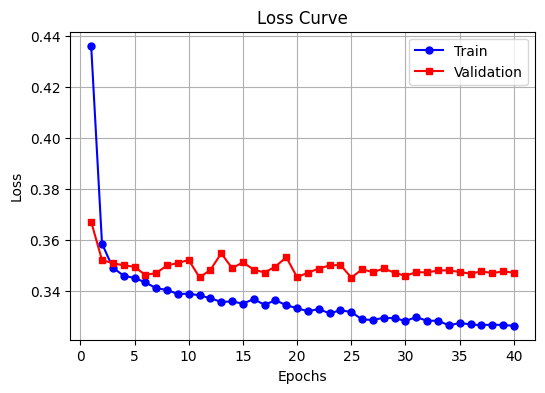

In [35]:
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(6, 4)) 
plt.plot(epochs, train_loss, 'bo-', label='Train', markersize=5, linewidth=1.5)  # Blue with circles
plt.plot(epochs, val_loss, 'rs-', label='Validation', markersize=5, linewidth=1.5)  # Red with squares
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

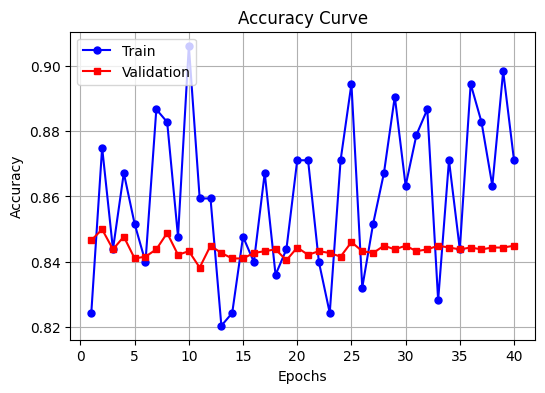

In [36]:
plt.figure(figsize=(6, 4))
plt.plot(epochs, train_acc, 'bo-', label='Train', markersize=5, linewidth=1.5)
plt.plot(epochs, val_acc, 'rs-', label='Validation', markersize=5, linewidth=1.5)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)
plt.show()


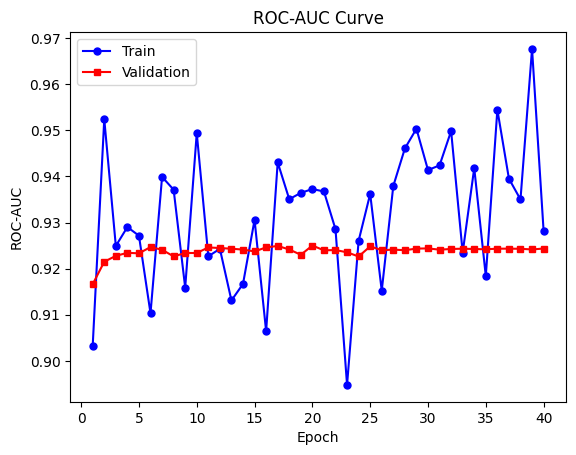

In [37]:
plt.plot(epochs, roc_auc_scores_train, 'bo-', label='Train', markersize=5, linewidth=1.5)
plt.plot(epochs, roc_auc_scores_val, 'rs-', label='Validation', markersize=5, linewidth=1.5)
plt.xlabel('Epoch')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC Curve')
plt.legend()
plt.show()


In [ ]:
checkpoint = torch.load("/kaggle/working/ParticleTransformer_latent_vectors_classification.pth")
model = ClassificationModel(features.shape[1], 1).to(device)
model.load_state_dict(checkpoint)
model.eval()

test_running_loss = 0.0
correct_predictions_test = 0
total_predictions_test = 0
y_true_test = []
y_scores_test = []

with torch.no_grad():
    for inputs_test, labels_test in dataset_loader.val_loader:
        inputs_test = inputs_test.to(device)
        # Convert labels to float, matching training if necessary
        labels_test = labels_test.to(device).float()
        
        # Permute input dimensions from (B, 32, 32, 2) to (B, 2, 32, 32)
        outputs_test = model(inputs_test)

        
        test_loss_batch = criterion(outputs_test, labels_test)
        test_running_loss += test_loss_batch.item()
        
        predicted_test = (outputs_test > 0.5).float()
        correct_predictions_test += (predicted_test == labels_test).sum().item()
        total_predictions_test += labels_test.size(0)
        
        y_true_test.extend(labels_test.cpu().numpy())
        y_scores_test.extend(outputs_test.cpu().detach().numpy())

# Use the val_loader length for computing average loss
test_loss = test_running_loss / len(dataset_loader.val_loader)
test_accuracy = correct_predictions_test / total_predictions_test
roc_auc_test = roc_auc_score(y_true_test, y_scores_test)
accuracy_test = accuracy_score(y_true_test, (np.array(y_scores_test) > 0.5))

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test ROC-AUC: {roc_auc_test:.4f}")

Test Loss: 0.3451, Test Accuracy: 0.8460, Test ROC-AUC: 0.9248


<ipython-input-38-638707735bee>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/kaggle/working/Resnet18_latent_vectors_classification.pth")


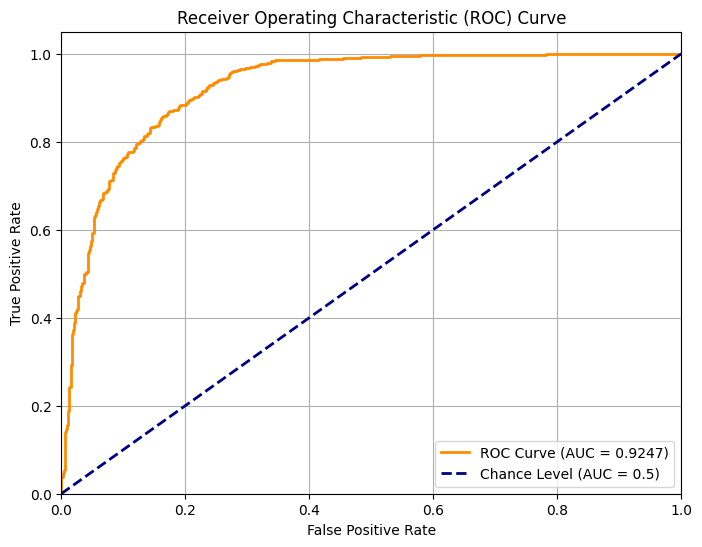

In [32]:

fpr, tpr, _ = roc_curve(y_true_test, y_scores_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance Level (AUC = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()